Imports

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

# from functools import reduce
# from operator import add
# from scipy.stats import ttest_ind, chi2_contingency
import pandas as pd
# from library import nl_utils
#from sql_scripts import sql_query_OOT
import numpy as np
from pathlib import Path
# from datetime import timedelta, date
from handlers import Session
# from dateutil.relativedelta import relativedelta
# from snowflake.connector.pandas_tools import write_pandas
from hyperopt import hp
import matplotlib.pyplot as plt
import shap
# from sklearn import metrics
# from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
# import seaborn as sns
# from IPython.display import display, HTML

from library import (
    # customer_parameters,
    data_preparation,
    nf_model_automl_binary,
    # nf_Performance_Summary,
    # evaluation_metrics
)
from library.data_preparation import holdout_data_preprocessing_table

from library.nf_model_automl_binary import nf_model_automl_binary,show_shap_and_pdp



c:\Users\mkelley\AppData\Local\miniconda3\envs\acq-mail-env\lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\mkelley\AppData\Local\miniconda3\envs\acq-mail-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metrics, Model name definition, vars

In [2]:
version = 'V1'
data_path = PROJECT_ROOT / "modeling_example.csv"
modeling_tbl = pd.read_csv(data_path).rename(columns=str.lower)
model_type = 'modeling_example' #Prescreen_resp
metric = 'flg_resp' 
save_model_artifacts = False

Reading in data

In [3]:
session = Session(use_log=True)
# session.log.info(f"Running 3.ModelDevelopment_{model_type}_{version}.py...")
session.log.info(f"Running 3.ModelDevelopment_EXAMPLE.py...")
mail_month = session.mail_dt.strftime('%Y%m')
mail_month_sql = session.mail_dt.strftime('%Y%m%d')
run_month_sql =   session.run_dt.strftime('%Y%m%d')



Preparing for feature engineering & model parameters

In [4]:
excluded_cols = ['mail_month','external_id','business_key','external_id','external_id.1','market_segment','list_name','run_date','rate_resp','rate_sub','rate_appr','rate_fund','fund_amt_per_deal','ctf','analytical_list_name','created_by',
                 'updated_by','model_created_date','model_updated_date','dbt_updated_at','dbt_created_at','nf_resp_scorebin','nf_sub_scorebin','flg_sub']
base_df = modeling_tbl #.sort_values(by=['accountnum'])
mdl_set = base_df.columns
final_vars =  [c for c in base_df.columns if c not in excluded_cols]
importance_vars = []
#duns_date_cols = []
base_df.shape

flg_ags = False
type_balanced = None #"balanced"
flg_log = False
flg_woe = False
eda_fit_feature_selection_execution=True

mandatory_cols = []
mandatory_cols = [c for c in mandatory_cols if c in final_vars]

Hyperparameter Tuning

In [5]:
custom_catboost_hyper  = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50),  # alias: iterations
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "reg_lambda": hp.uniform("reg_lambda", 1, 3),  # alias: l2_leaf_reg
    "learning_rate": hp.uniform("learning_rate", 0.001, 0.05),
    "bagging_temperature": hp.quniform("bagging_temperature", 0.1, 1.0, 0.2),
    "scale_pos_weight": hp.quniform("scale_pos_weight", 0.01, 1.0, 0.2),
    "colsample_bylevel": hp.quniform("colsample_bylevel", 0.3, 0.9, 0.2),
    "subsample": hp.quniform("subsample", 0.2, 0.9, 0.2),
    "min_child_samples": hp.quniform("min_child_samples", 5, 30, 5)

}

custom_lgbm_hyper  = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50),  # alias: iterations
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 1, 3),
    "reg_lambda": hp.uniform("reg_lambda", 1, 3),  # alias: l2_leaf_reg
    "learning_rate": hp.uniform("learning_rate", 0.001, 0.05),
    "subsample": hp.quniform("subsample", 0.5, 0.9, 0.2),  # alias: bagging_fraction
    "pos_bagging_fraction": hp.quniform("pos_bagging_fraction", 0.1, 1.0, 0.2),  # for imbalanced data
    "neg_bagging_fraction": hp.quniform("neg_bagging_fraction", 0.1, 1.0, 0.2),  # use with pos_bagging_fraction
    "colsample_bytree": hp.quniform("colsample_bytree", 0.3, 0.9, 0.2),
   "min_child_samples": hp.quniform("min_child_samples", 5, 30, 5)
  # alias: min_data_in_leaf
}

custom_xgb_hyper  = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50),
    "max_depth": hp.quniform("max_depth", 2, 5, 1),  # np.arange(3, 8, dtype=int)
    "reg_alpha": hp.uniform("reg_alpha", 1, 3),  # L1 regularization
    "reg_lambda": hp.uniform("reg_lambda", 1, 3),  # L2 regularization
    "gamma": hp.quniform("gamma", 0.0, 1.0, 0.001),  # min loss reduction for splits
    "learning_rate": hp.uniform("learning_rate", 0.001, 0.05),
    "scale_pos_weight": hp.quniform("scale_pos_weight", 0.01, 1.0, 0.2),  # class imbalance ratio
    "colsample_bylevel": hp.quniform("colsample_bylevel", 0.3, 0.9, 0.2),  # alias: colsample_bytree
    "subsample": hp.quniform("subsample", 0.2, 0.9, 0.2),  # random sample before growing trees
    "min_child_weight": hp.quniform("min_child_weight", 0.01, 0.1, 0.01)
}


Feature Engineering & Importance

In [6]:
#Empty Dataframe
newDF,woeDF = pd.DataFrame(), pd.DataFrame()
#Extract Column Names
cols = base_df.columns
#Run WOE and IV on all the independent variables
eda_vars = list(final_vars + importance_vars  + mandatory_cols)
cat_cols = [c for c in base_df.select_dtypes(include='object').columns]
cat_cols = [c for c in cat_cols if c in eda_vars and c!= metric]
num_cols = [c for c in base_df.columns if c not in cat_cols and c != metric]
#eda_vars = list(final_vars + importance_vars + duns_date_cols + mandatory_cols + [metric, 'mail_date'])


df_fe, fe_woeDF, log_cols = data_preparation.modeling_data_preprocessing_table(df = base_df, 
                                                    label = metric, 
                                                    cat_cols = cat_cols, 
                                                    num_cols = num_cols,
                                                    var_cols = eda_vars, 
                                                    type_balanced = type_balanced, 
                                                    flg_log = flg_log, 
                                                    flg_woe = flg_woe)
                                                
model = nf_model_automl_binary()
model.catboost_hyper = custom_catboost_hyper
model.lgbm_hyper = custom_lgbm_hyper
model.xgb_hyper = custom_xgb_hyper

# set model parameters
model.top_n_prnct = 0.90
model.missing_threshold = 0.75
model.correlation_threshold = 0.8
model.vif_threshold = 4
#model.drop_list = drop_list
model.fixed_vars = mandatory_cols
model.categorical_vars = [] # categorical variables cannot be used with mode as 'xgb' 
model.stratify_vars = []  # list of columns to have stratify split of train-test 
model.max_features = 5  ## upper-limit/maximum number of columns (excluding fixed_vars) to shortlist in eda_fit_feature_selection
model.kfolds = 3  # (0 --> does not run k-fold ; higher the value more time it will take to run)
#model.exclusion_list = [c for c in ['duns', 'mail_date', 'load_year_prior', 'load_month_prior', 'campaignid', 'accountnum', 'r', 'load_year', 'load_month', 'flg_resp', 'flg_qual', 'flg_sub', 'flg_appr', 'flg_fund', 'flg_NFappr', 'flg_NFfund', 'fund_amt', 'NFfund_amt', 'funded_margin', 'NFfund_margin', 'ucc_filing_date', 'ref_score'] if (c != metric) & (c in df_fe.columns)]  # list of comp_against vars not to include in model building, just to be considered for comparison purpose
model.exclusion_list = []  

model.test_size = 0.2 
#model.input_duns_col = "duns"
model.target = metric
model.param_dict = {
    #'weight': weight,
    'test_size': 0.2,
    'n_iter': 3,  # number of model user wants to train as part of hyper-parameter tuning
    'n_jobs': -1  # number of cores user wants to use during model training. -1 means it will use all the available cores in driver node
}
model.imp_woe = fe_woeDF
model.log_cols = log_cols

model.eda_fit_feature_selection(df_fe, execution=eda_fit_feature_selection_execution)


Choosing best model

[INFO] shape of train dataset is (8000, 10) 
	 * shape of test dataset is (2000, 10)

---------------------- CatBoost Hyper-parameters tuning started ----------------------
{'bagging_temperature': 0.8, 'colsample_bylevel': 0.4, 'learning_rate': 0.013686690318553369, 'max_depth': 2.0, 'min_child_samples': 15.0, 'n_estimators': 350.0, 'reg_lambda': 1.77148935479755, 'scale_pos_weight': 0.8, 'subsample': 0.4}
[LOGS] mean cross validation score: 0.996624999894518
{'bagging_temperature': 0.8, 'colsample_bylevel': 0.8, 'learning_rate': 0.04875895275251839, 'max_depth': 3.0, 'min_child_samples': 5.0, 'n_estimators': 800.0, 'reg_lambda': 1.76997675516473, 'scale_pos_weight': 0.0, 'subsample': 0.4}
[LOGS] mean cross validation score: 0.996624999894518                             
{'bagging_temperature': 0.4, 'colsample_bylevel': 0.8, 'learning_rate': 0.024956519494649654, 'max_depth': 3.0, 'min_child_samples': 15.0, 'n_estimators': 900.0, 'reg_lambda': 2.4226589119752475, 'scale_pos_weight': 0.

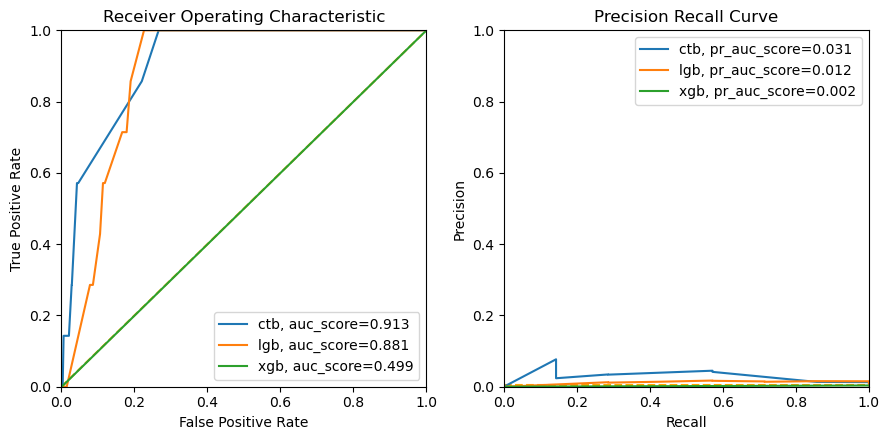

,Dev,OOT(tst),Diff,Bad_Rate,Best_N_Tree
ROC_AUC,0.773144,0.912838,-0.139694,False,350.0
Gini,0.546288,0.825676,-0.279387,False,350.0
KS,45.3382,70.2459,-24.9077,False,350.0
10%,37.037037,57.142857,-20.10582,False,350.0
20%,51.851852,85.714286,-33.862434,False,350.0
max_prob,0.079159,0.080078,-0.000919,False,350.0
min_prob,0.049292,0.050756,-0.001464,False,350.0
,Dev,OOT(tst),Diff,Bad_Rate,Best_N_Tree
ROC_AUC,0.760655,0.880905,-0.120249,False,100
Gini,0.52131,0.761809,-0.240499,False,100


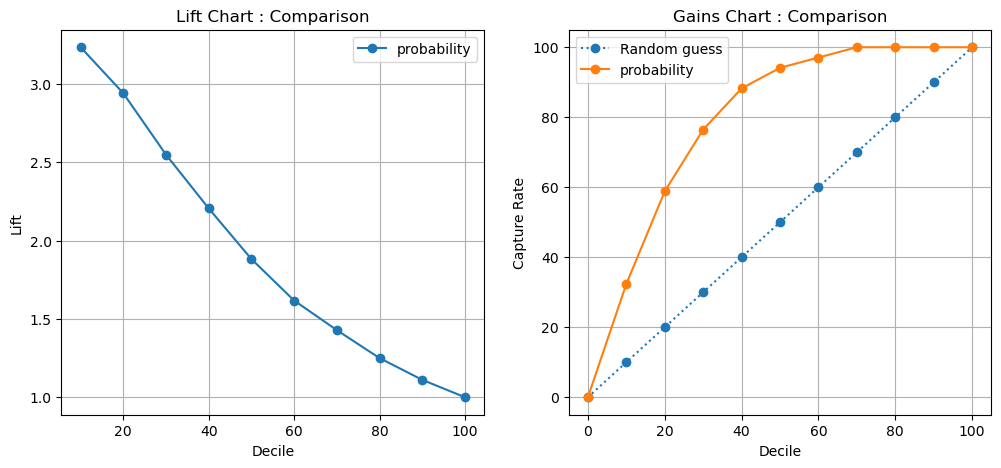


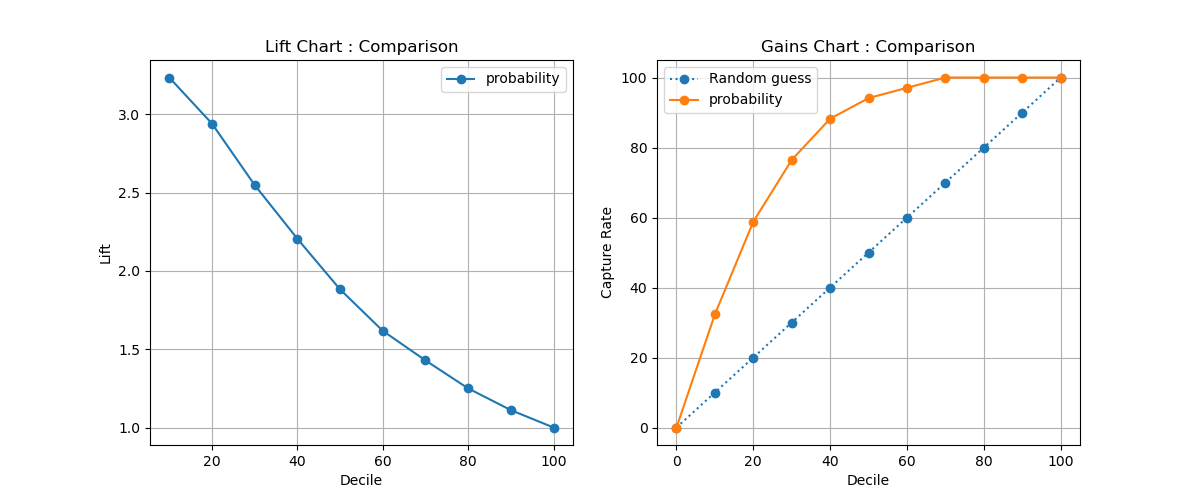

In [7]:
model.df_pandas = model.df_pandas.loc[:, ~model.df_pandas.columns.duplicated()]
model.X = [x for x in model.X if x in model.df_pandas.columns]

model.param_dict.update({
    'target': model.target,
    'weight': model.weight
})

model.fit_multi_iter(model.df_pandas)

chosen_model = model.best_iter_comp(ctb_nth_iter = None, lgb_nth_iter = None, xgb_nth_iter = None, best_model_measure='auc')
model.metric_comparison_report()
model.fit(final_model = chosen_model)
model.enable_report()
model.generate_report2()
model.generate_charts()


# # ------------------------------------- Save the model artifacts for production ---------
# if save_model_artifacts:
#     mlflow_info = model.log_this_iteration()
#     model_name = model_name_flg(model_name, flg_ags, type_balanced, flg_log, flg_woe)

Final Model Evaluation Metrics

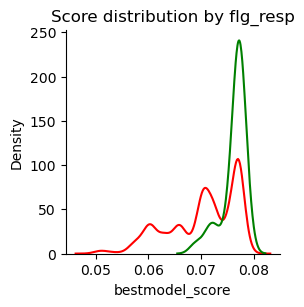

roc_auc: 0.802
accuracy: 0.997
precision: 0.000
recall: 0.000
f1_score: 0.000
capture_rate_10%: 0.324
capture_rate_20%: 0.588


In [8]:
modeling_df = holdout_data_preprocessing_table(modeling_tbl, 
                                            model.X, 
                                            model.cols_catg,
                                            model.log_cols, 
                                            model.imp_woe,
                                            metric)

modeling_df_scored = model.score(modeling_df)
model.gen_evaluation_metrics_new(
    dff=modeling_df_scored,
    score_col_name='proba_bad',
    metric=metric
)


[INFO] SHAP Feature Importance


,col_name,feature_importance_vals
1,paydex,0.037365
2,sales_volume,0.036503
5,rate_qual,0.033230
7,is_rdi,0.029000
0,emp_total,0.001201
3,legal_status,0.000392
6,is_ppp,0.000143
4,brand_code,0.000000


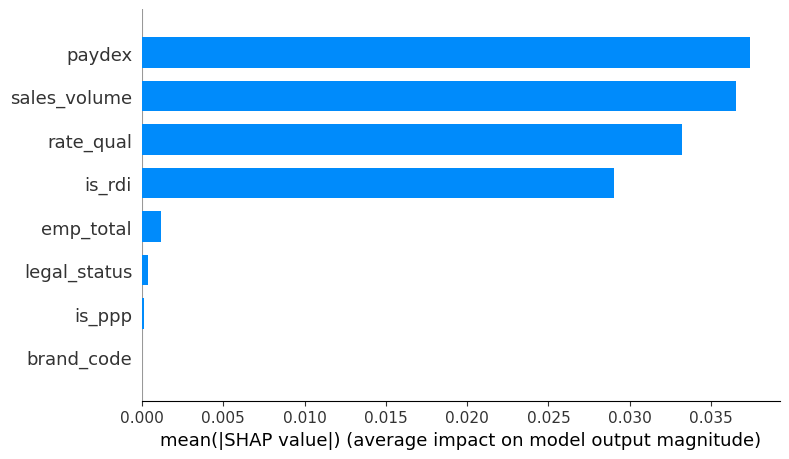

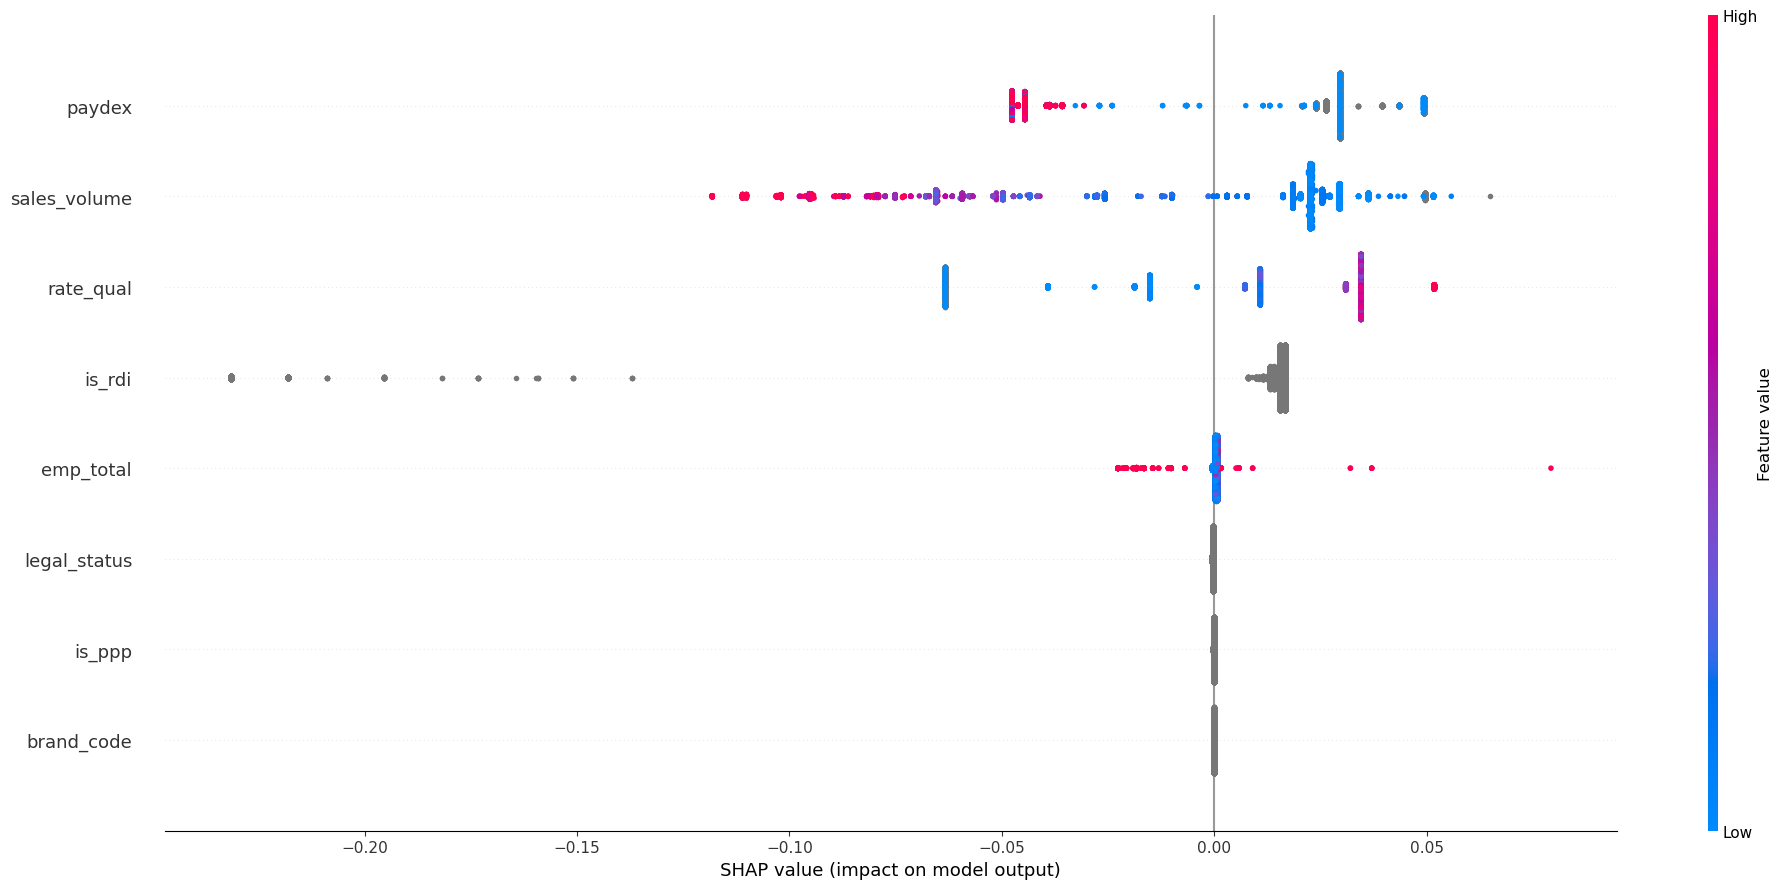

<Figure size 1800x1600 with 0 Axes>

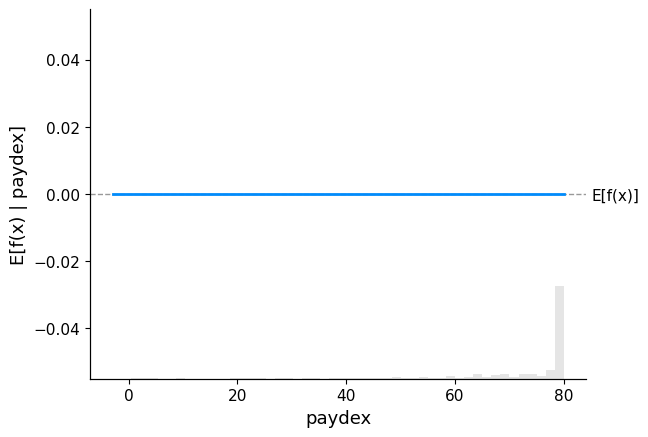

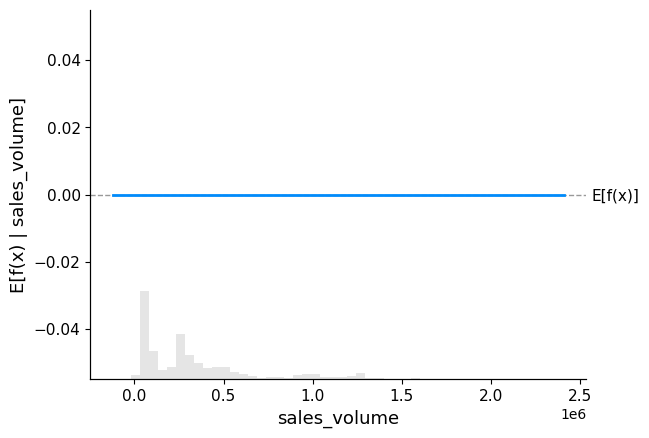

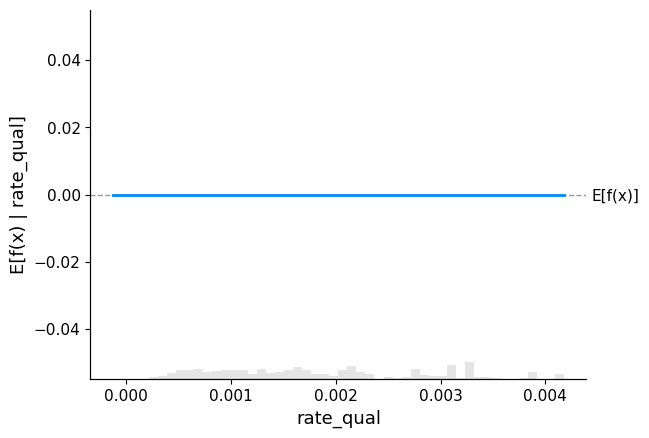

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [9]:
show_shap_and_pdp(
    model=model.finalmodel,
    df=modeling_df,
    feature_cols=model.X
)